# Speech Signals: Sampling + Quantization (Hands-On)

In this notebook, you will:
1. Load or record a short speech clip.
2. Create **sampling-rate** variants (8 kHz / 16 kHz / 44.1 kHz) using resampling.
3. Create **bit-depth** variants (16-bit / 8-bit / 4-bit) using quantization.
4. Listen to each version and visualize waveform (and optionally spectrogram).
5. Answer a few conceptual questions.

**Key notation:**
- Continuous-time: \( x(t) \)
- Sampled (discrete-time): \( x[n] \)
- Quantized (digital): \( x_q[n] \)
- Sampling frequency: \( f_s \) (samples/sec)
- Sampling period: \( T = 1/f_s \)

## 1) Setup

We will use:
- `numpy` for arrays
- `soundfile` to read/write wav files
- `scipy.signal.resample_poly` for high-quality resampling
- `matplotlib` for plots
- (optional) `sounddevice` for recording from microphone
- `IPython.display.Audio` for listening in the notebook

If you see an import error, install the missing package using pip.

In [2]:
# If you're missing packages, uncomment and run this cell.
# !pip -q install numpy scipy matplotlib soundfile librosa sounddevice

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import soundfile as sf
from scipy.signal import resample_poly

# Optional for spectrograms
import librosa
import librosa.display

# Audio playback in notebooks
from IPython.display import Audio, display

## 2) Load or Record a Speech Clip

Choose ONE option:

### Option A (easiest): Load a WAV file
- Put a file called `speech.wav` in the same folder as this notebook.

### Option B (local mic recording): Record using `sounddevice`
- Works well on local machines (Mac/Windows/Linux), not always on remote servers.

We will normalize audio to [-1, 1] to avoid clipping.

In [4]:
# Option A

WAV_PATH = "kdt_001.wav"  # change if needed

if not os.path.exists(WAV_PATH):
    raise FileNotFoundError(
        f"Could not find '{WAV_PATH}'.\n"
        "Please place a short WAV file named 'speech.wav' in the same folder,\n"
        "or update WAV_PATH to point to your file."
    )

x, fs_orig = sf.read(WAV_PATH)

# If stereo, convert to mono
if x.ndim == 2:
    x = x.mean(axis=1)

# Convert to float and normalize
x = x.astype(np.float32)
x = x / (np.max(np.abs(x)) + 1e-12)

print("Loaded:", WAV_PATH)
print("Original sampling rate:", fs_orig, "Hz")
print("Duration (sec):", len(x)/fs_orig)
print("Num samples:", len(x))

display(Audio(x, rate=fs_orig))

Loaded: kdt_001.wav
Original sampling rate: 16000 Hz
Duration (sec): 3.5170625
Num samples: 56273


In [42]:
# Option B

import sounddevice as sd

fs_orig = 16000          # record directly at 16 kHz for speech
duration = 3.0           # seconds

print("Recording... Speak now!")
rec = sd.rec(int(duration * fs_orig), samplerate=fs_orig, channels=1, dtype='float32')
sd.wait()
x = rec[:, 0]

# Normalize
x = x / (np.max(np.abs(x)) + 1e-12)

print("Done recording.")
print("Sampling rate:", fs_orig, "Hz")
print("Num samples:", len(x))

# Save (optional)
sf.write("speech.wav", x, fs_orig)
print("Saved to speech.wav")

display(Audio(x, rate=fs_orig))

Recording... Speak now!
Done recording.
Sampling rate: 16000 Hz
Num samples: 48000
Saved to speech.wav


## 3) Create a 16 kHz Reference Clip

We want a consistent baseline:
- Reference sampling rate: **16 kHz**
- Duration: **3 seconds** (trim for speed and consistent comparisons)

If the audio is not already 16 kHz, we resample it.

In [5]:
FS_REF = 16000
DURATION_SEC = 3.0

def resample_to(sig, fs_in, fs_out):
    """High-quality rational-factor resampling using polyphase filtering."""
    from math import gcd
    g = gcd(fs_in, fs_out)
    up = fs_out // g
    down = fs_in // g
    y = resample_poly(sig, up, down).astype(np.float32)
    y = y / (np.max(np.abs(y)) + 1e-12)
    return y

# Ensure x16 is 16 kHz
if fs_orig != FS_REF:
    x16 = resample_to(x, fs_orig, FS_REF)
else:
    x16 = x.copy()

# Trim to exactly 3 seconds (or shorter if clip is shorter)
N16 = int(FS_REF * DURATION_SEC)
x16 = x16[:min(len(x16), N16)]

print("Reference clip fs:", FS_REF)
print("Reference duration (sec):", len(x16)/FS_REF)
print("Reference samples:", len(x16))

display(Audio(x16, rate=FS_REF))

Reference clip fs: 16000
Reference duration (sec): 3.0
Reference samples: 48000


## 4) Plot the Waveform

We’ll plot a short segment (e.g., first 1500 ms).
This visually shows how dense samples are at a given sampling rate.

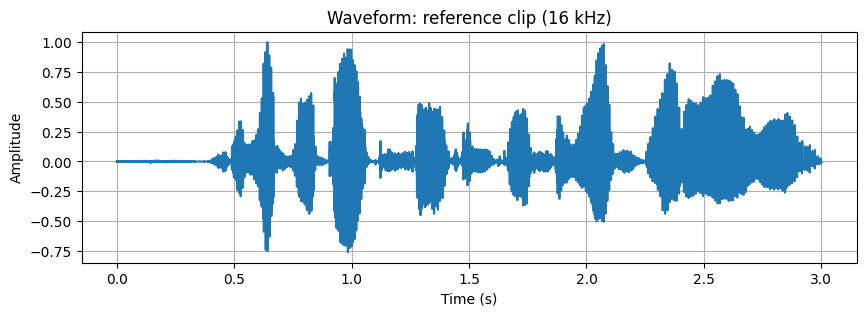

In [6]:
FS_REF=16000
def plot_waveform(x, fs, title, seconds_to_show=3):
    n = int(fs * seconds_to_show)
    n = min(n, len(x))
    t = np.arange(n) / fs

    plt.figure(figsize=(10, 3))
    plt.plot(t, x[:n])
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_waveform(x, FS_REF, "Waveform: reference clip (16 kHz)")

## 5) Sampling Rate Experiment (8 kHz / 16 kHz / 44.1 kHz)

We resample the 16 kHz reference to different sampling rates and listen.

**Intuition:**
- Lower \( f_s \) = fewer samples per second = less time detail
- Very low \( f_s \) can lose important speech components

In [7]:
sampling_rates = [2000, 4000, 8000, 16000, 44100]
resampled = {}

for fs_new in sampling_rates:
    if fs_new == FS_REF:
        resampled[fs_new] = x16
    else:
        resampled[fs_new] = resample_to(x16, FS_REF, fs_new)

print("Created resampled versions:", list(resampled.keys()))

Created resampled versions: [2000, 4000, 8000, 16000, 44100]



--- Resampled to 2000 Hz ---
Num samples: 6000 Duration: 3.0 sec


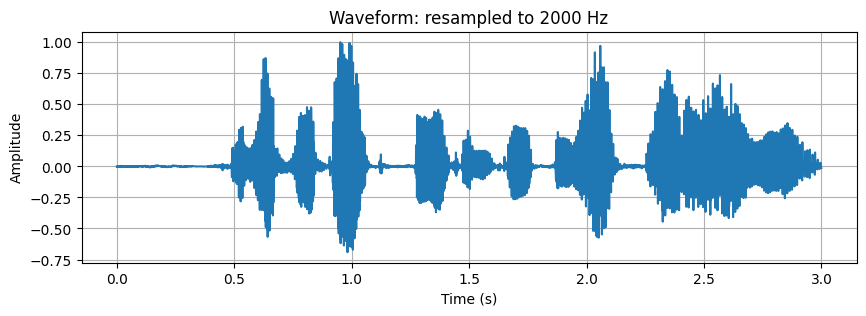


--- Resampled to 4000 Hz ---
Num samples: 12000 Duration: 3.0 sec


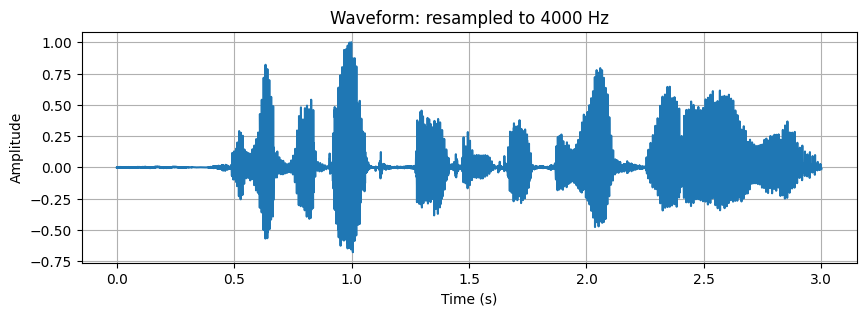


--- Resampled to 8000 Hz ---
Num samples: 24000 Duration: 3.0 sec


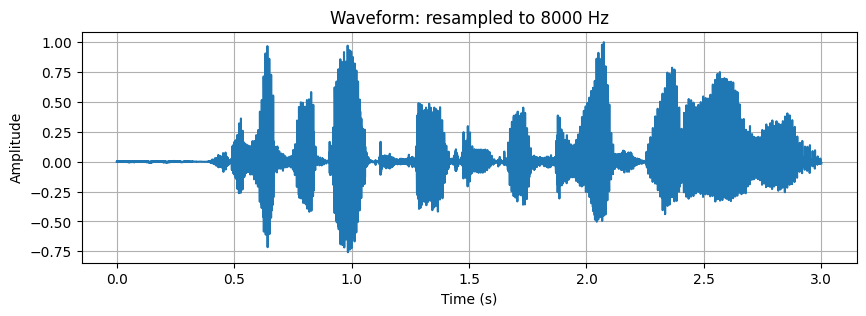


--- Resampled to 16000 Hz ---
Num samples: 48000 Duration: 3.0 sec


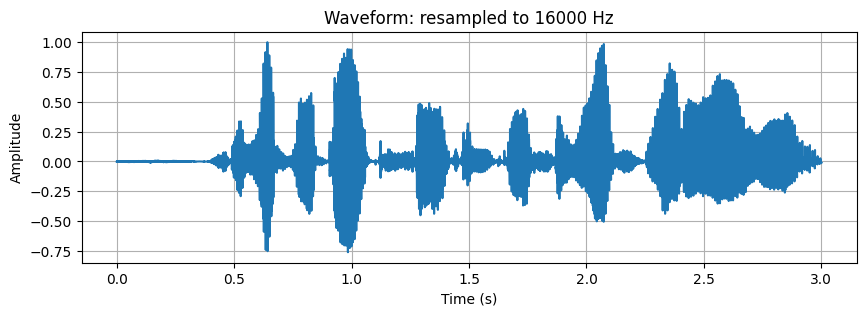


--- Resampled to 44100 Hz ---
Num samples: 132300 Duration: 3.0 sec


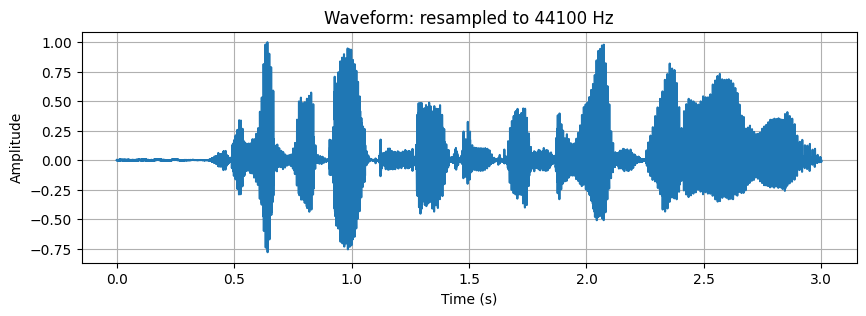

In [8]:
for fs_new in sampling_rates:
    y = resampled[fs_new]
    print(f"\n--- Resampled to {fs_new} Hz ---")
    print("Num samples:", len(y), "Duration:", len(y)/fs_new, "sec")

    plot_waveform(y, fs_new, f"Waveform: resampled to {fs_new} Hz")
    display(Audio(y, rate=fs_new))

## 6) Quantization / Bit Depth Experiment (16-bit → 8-bit → 4-bit)

Quantization makes amplitude values discrete.
We simulate different bit depths by rounding to fewer amplitude levels.

**Formula:**
- Number of quantization levels: \( L = 2^B \)

**Intuition:**
- Fewer bits → fewer levels → bigger rounding errors → more audible distortion ("grainy", "buzzy")

In [9]:
def quantize_uniform(sig, bits):
    """
    Uniform signed quantization for signals in [-1, 1].
    Returns quantized signal x_q in [-1, 1].
    """
    sig = np.clip(sig, -1.0, 1.0)

    # Signed integer range: [-max_int, max_int]
    max_int = (2 ** (bits - 1)) - 1  # 16-bit -> 32767, 8-bit -> 127, 4-bit -> 7
    q = np.round(sig * max_int) / max_int
    return q.astype(np.float32)

def mse(a, b):
    return float(np.mean((a - b) ** 2))

In [10]:
bit_depths = [16, 8, 4, 2]
quantized = {}

for b in bit_depths:
    quantized[b] = quantize_uniform(x16, b)

print("Created quantized versions (all at 16 kHz):", bit_depths)

Created quantized versions (all at 16 kHz): [16, 8, 4, 2]



--- Quantized to 16-bit @ 16 kHz ---
MSE vs 16-bit baseline: 1.0695370804281179e-11


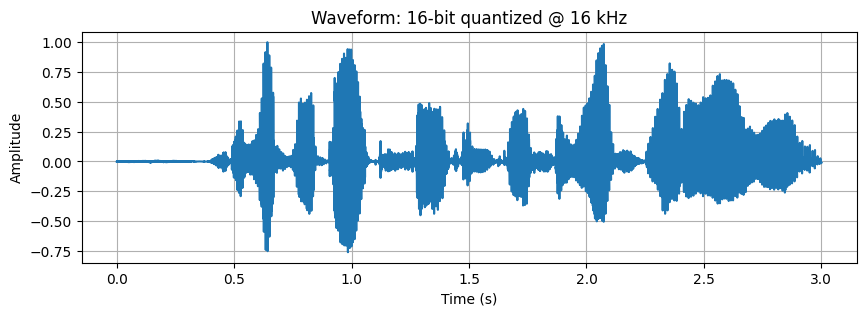


--- Quantized to 8-bit @ 16 kHz ---
MSE vs 16-bit baseline: 4.886490842181956e-06


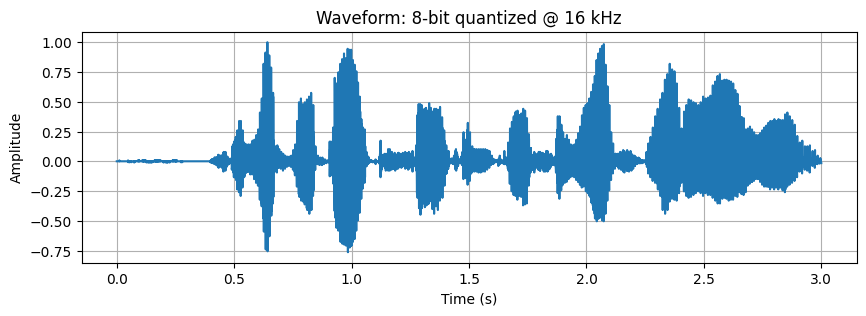


--- Quantized to 4-bit @ 16 kHz ---
MSE vs 16-bit baseline: 0.0011180377332493663


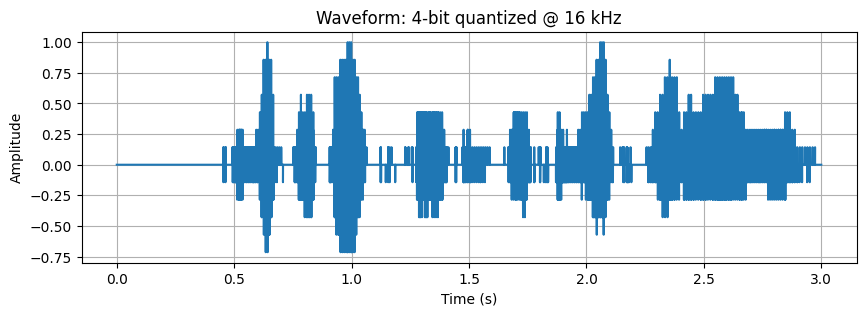


--- Quantized to 2-bit @ 16 kHz ---
MSE vs 16-bit baseline: 0.011483864858746529


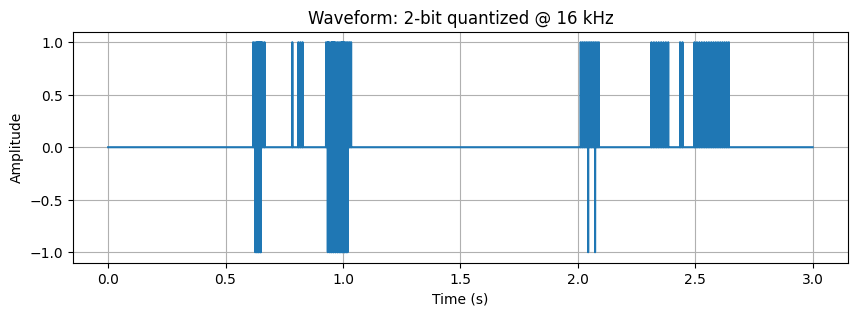

In [12]:
for b in bit_depths:
    qsig = quantized[b]
    print(f"\n--- Quantized to {b}-bit @ 16 kHz ---")
    print("MSE vs 16-bit baseline:", mse(x16, qsig))

    plot_waveform(qsig, FS_REF, f"Waveform: {b}-bit quantized @ 16 kHz")
    display(Audio(qsig, rate=FS_REF))

## 7) Combine Sampling Rate + Bit Depth (Optional but insightful)

Now we simulate "phone-like" audio:
- sampling rate = 8 kHz
Then apply different bit depths to the 8 kHz signal.

In [13]:
fs_phone = 16000
phone_sig = resampled[fs_phone]

phone_quantized = {}
for b in [16, 8, 4, 2]:
    phone_quantized[b] = quantize_uniform(phone_sig, b)

print("Created combined versions: 8 kHz with 16/8/4 bit depth.")

Created combined versions: 8 kHz with 16/8/4 bit depth.



--- 8 kHz + 16-bit ---


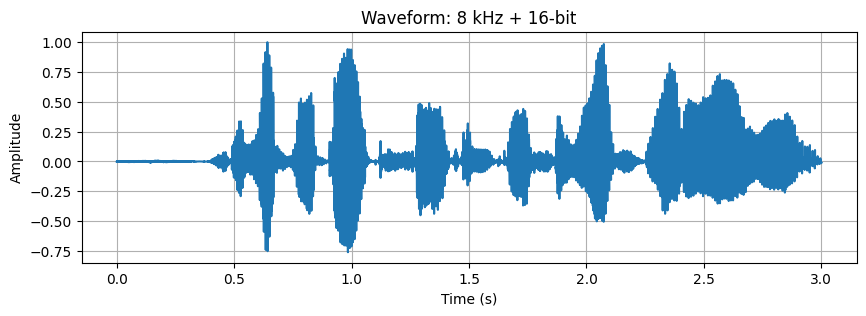


--- 8 kHz + 8-bit ---


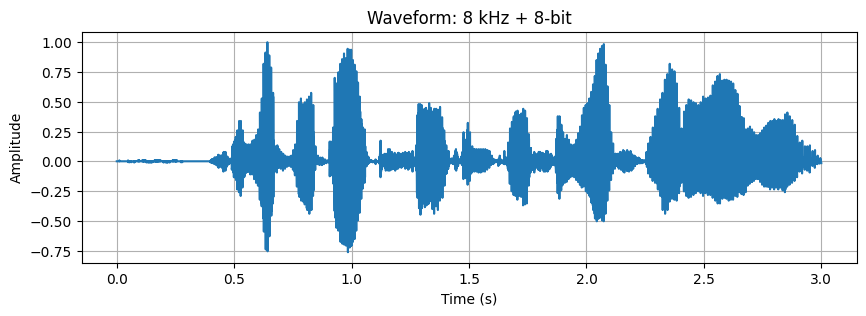


--- 8 kHz + 4-bit ---


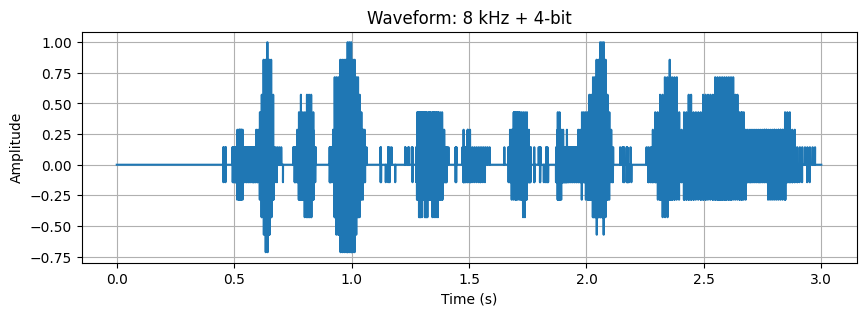


--- 8 kHz + 2-bit ---


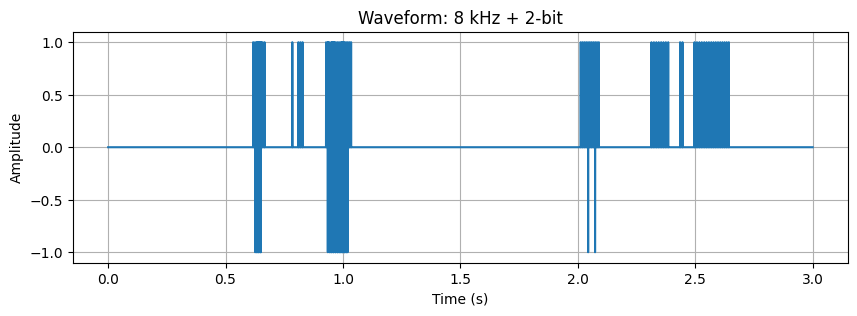

In [14]:
for b in [16, 8, 4, 2]:
    y = phone_quantized[b]
    print(f"\n--- 8 kHz + {b}-bit ---")
    plot_waveform(y, fs_phone, f"Waveform: 8 kHz + {b}-bit")
    display(Audio(y, rate=fs_phone))

## 8) Optional: Spectrogram Visualization

Spectrogram shows how energy is distributed over frequency vs time.
It’s useful to *see* what gets lost at lower sampling rates.

Tip:
- 8 kHz sampling rate can only represent frequencies up to ~4 kHz (conceptually).

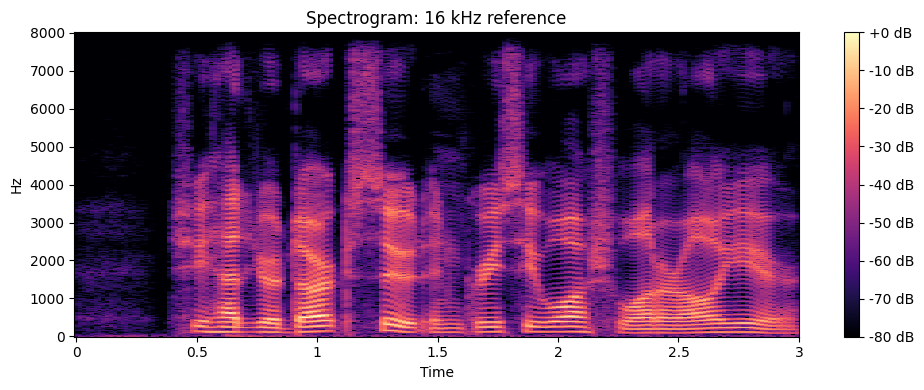

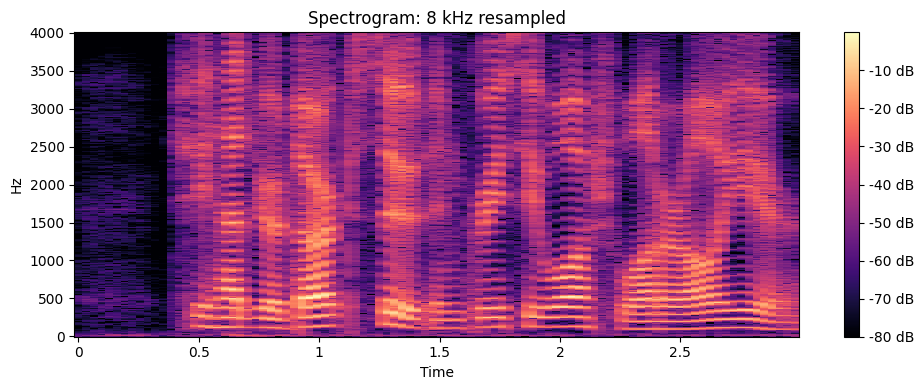

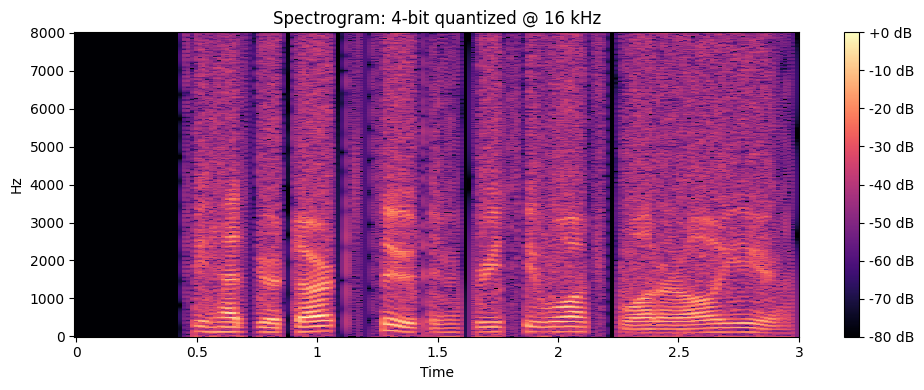

In [15]:
def plot_spectrogram(sig, fs, title, n_fft=1024, hop=256):
    S = np.abs(librosa.stft(sig, n_fft=n_fft, hop_length=hop))
    S_db = librosa.amplitude_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=fs, hop_length=hop, x_axis='time', y_axis='hz')
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_spectrogram(x16, FS_REF, "Spectrogram: 16 kHz reference")
plot_spectrogram(resampled[8000], 8000, "Spectrogram: 8 kHz resampled")
plot_spectrogram(quantized[4], FS_REF, "Spectrogram: 4-bit quantized @ 16 kHz")

## 9) Save Outputs (Optional)

We save:
- resampled versions
- quantized versions
- combined versions (8 kHz + bit-depth changes)

This makes it easy to compare in any audio player.

In [16]:
OUT_DIR = "outputs_signal101"
os.makedirs(OUT_DIR, exist_ok=True)

# Save resampled
for fs_new, y in resampled.items():
    sf.write(os.path.join(OUT_DIR, f"speech_resampled_{fs_new}Hz.wav"), y, fs_new)

# Save quantized at 16k
for b, y in quantized.items():
    sf.write(os.path.join(OUT_DIR, f"speech_quantized_{b}bit_16k.wav"), y, FS_REF)

# Save combined
for b, y in phone_quantized.items():
    sf.write(os.path.join(OUT_DIR, f"speech_8k_{b}bit.wav"), y, fs_phone)

print("Saved all outputs to:", OUT_DIR)

Saved all outputs to: outputs_signal101


## 10) Questions (submit short answers)

1) How many samples are in a 3-second clip at 16 kHz?

2) What changes in the waveform plot when \( f_s \) decreases?

3) What audible artifacts appear when bit depth decreases?

4) Which hurts intelligibility more (in your examples): low sampling rate or low bit depth?

5) (Optional) What differences do you see in spectrograms at 8 kHz vs 16 kHz?